<a href="https://colab.research.google.com/github/plushvoxel/Project-Lernende-Agenten-colab/blob/master/CNNTest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import random
import numpy as np
import tensorflow as tf
from tarfile import open as taropen
from urllib import request
from struct import unpack
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0" #for training on gpu

In [0]:
def create_data():
    DataBaseURL= "http://computer-in.love/data/{}.tar"
    Classes = ["fm", "pager", "smartwares", "no_signal"]
    data = []
    normalisationFactor = 100
    test = 0

    for modulation in Classes:
        filename = "{}.tar".format(modulation)
        request.urlretrieve(DataBaseURL.format(modulation), filename)
        tar = taropen(filename)
        class_label = [0]*len(Classes)
        class_label[Classes.index(modulation)]=1
        for member in tar.getmembers():
            test = test + 1
            with tar.extractfile(member) as f:
                sample = []
                buffer = f.read()
                num_floats = len(buffer)//4
                floats = unpack("f"*num_floats, buffer)
                i = floats[0::2]
                q = floats[1::2]
                for j in range(min(len(i), len(q))):
                    #here happens the scaling or whatever you want
                    sample.append([i[j]/normalisationFactor, q[j]/normalisationFactor])
                #here happens some cross_feature if you want. just append it to the sample
                
                data.append([np.array(sample), np.array(class_label)])
    random.shuffle(data)

    return data

In [0]:
def get_data(data,trainP = 60, valP= 20, testP = 20):
  pre: trainP + valP + testP <= 100
  size =len(data)
  trainSize = (size * trainP)//100
  print(trainSize)
  valSize = (size * valP)//100
  print(valSize)
  testSize = (size * testP)//100
  print(testSize)
  train = data[:trainSize]
  val = data[trainSize: trainSize + valSize]
  test = data[trainSize + valSize: trainSize + valSize + testSize]
  x_train = []
  y_train = []
  x_val = []
  y_val = []
  x_test = []
  y_test = []
  for sample, target in train:
    x_train.append(sample)
    y_train.append(target)
  for sample, target in val:
    x_val.append(sample)
    y_val.append(target)
  for sample, target in test:
    x_test.append(sample)
    y_test.append(target)


  return np.array(x_train), np.array(x_val), np.array(x_test), np.array(y_train), np.array(y_val), np.array(y_test) 

In [0]:
data= create_data()

In [5]:
train_X, val_X, test_X, train_y, val_y, test_y = get_data(data)

23888
7962
7962


In [6]:
print(np.max(train_X[0]))
print(val_X.shape)

0.4851842498779297
(7962, 128, 2)


In [0]:
train_X = train_X.reshape(-1, 128, 2, 1)
test_X = test_X.reshape(-1,128,2,1)
val_X = val_X.reshape(-1,128,2,1)

In [0]:
training_iters = 100 
learning_rate = 0.001 
batch_size = 50
#data input (img shape: 128*2)
n_input_1 = 128
n_input_2 = 2

# data total classes (0-9 digits)
n_classes = 4
tf.reset_default_graph()
#both placeholders are of type float
x = tf.placeholder("float", [None, n_input_1,n_input_2,1])
y = tf.placeholder("float", [None, n_classes])

In [0]:
def conv2d(x, W, b, strides=1):
    # Conv2D wrapper, with bias and relu activation
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x) 

def maxpool2d(x, k=2):
    return tf.nn.max_pool(x, ksize=[1, k, 1, 1], strides=[1, k, 1, 1],padding='SAME')

In [0]:

weights = {
    'wc1': tf.get_variable('W0', shape=(11,2,1,8), initializer=tf.contrib.layers.xavier_initializer()), 
    'wc2': tf.get_variable('W1', shape=(11,2,8,8), initializer=tf.contrib.layers.xavier_initializer()), 
    #'wc3': tf.get_variable('W2', shape=(11,2,16,32), initializer=tf.contrib.layers.xavier_initializer()), 
    'wd1': tf.get_variable('W3', shape=(8*32*2,8), initializer=tf.contrib.layers.xavier_initializer()), 
    'out': tf.get_variable('W6', shape=(8,n_classes), initializer=tf.contrib.layers.xavier_initializer()), 
}
biases = {
    'bc1': tf.get_variable('B0', shape=(8), initializer=tf.contrib.layers.xavier_initializer()),
    'bc2': tf.get_variable('B1', shape=(8), initializer=tf.contrib.layers.xavier_initializer()),
    #'bc3': tf.get_variable('B2', shape=(32), initializer=tf.contrib.layers.xavier_initializer()),
    'bd1': tf.get_variable('B3', shape=(8), initializer=tf.contrib.layers.xavier_initializer()),
    'out': tf.get_variable('B4', shape=(n_classes), initializer=tf.contrib.layers.xavier_initializer()),
}

In [0]:
def conv_net(x, weights, biases):  

    # here we call the conv2d function we had defined above and pass the input image x, weights wc1 and bias bc1.
    conv1 = conv2d(x, weights['wc1'], biases['bc1'])
    # Max Pooling (down-sampling), this chooses the max value from a 2*1 matrix window and outputs a 64*2 matrix.
    conv1 = maxpool2d(conv1, k=2)

    # Convolution Layer
    # here we call the conv2d function we had defined above and pass the input image x, weights wc2 and bias bc2.
    conv2 = conv2d(conv1, weights['wc2'], biases['bc2'])
    # Max Pooling (down-sampling), this chooses the max value from a 2*1 matrix window and outputs a 32*2 matrix.
    conv2 = maxpool2d(conv2, k=2)

    #conv3 = conv2d(conv2, weights['wc3'], biases['bc3'])
    # Max Pooling (down-sampling), this chooses the max value from a 2*1 matrix window and outputs a 16*2.
    #conv3 = maxpool2d(conv3, k=2)


    # Fully connected layer
    # Reshape conv2 output to fit fully connected layer input
    
    fc1 = tf.reshape(conv2, [-1, weights['wd1'].get_shape().as_list()[0]])
    fc1 = tf.add(tf.matmul(fc1, weights['wd1']), biases['bd1'])
    fc1 = tf.nn.relu(fc1)
    # Output, class prediction
    # finally we multiply the fully connected layer with the weights and add a bias term. 
    out = tf.add(tf.matmul(fc1, weights['out']), biases['out'])
    return out

In [0]:
pred = conv_net(x, weights, biases)

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=pred, labels=y))

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

#Here you check whether the index of the maximum value of the predicted image is equal to the actual labelled image. and both will be a column vector.
correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))

#calculate accuracy across all the given images and average them out. 
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [0]:
init = tf.global_variables_initializer()

Iter 0, Loss= 1.536821, Training Accuracy= 0.25554
Validation Accuracy: 0.24818
Validation Loss: 1.53769
Iter 1, Loss= 1.486830, Training Accuracy= 0.25558
Validation Accuracy: 0.24818
Validation Loss: 1.49107
Iter 2, Loss= 1.463845, Training Accuracy= 0.25383
Validation Accuracy: 0.24818
Validation Loss: 1.46818
Iter 3, Loss= 1.450538, Training Accuracy= 0.25374
Validation Accuracy: 0.24818
Validation Loss: 1.45626
Iter 4, Loss= 1.440044, Training Accuracy= 0.25364
Validation Accuracy: 0.24818
Validation Loss: 1.44623
Iter 5, Loss= 1.434109, Training Accuracy= 0.25363
Validation Accuracy: 0.24818
Validation Loss: 1.44023
Iter 6, Loss= 1.433527, Training Accuracy= 0.25313
Validation Accuracy: 0.24818
Validation Loss: 1.43910
Iter 7, Loss= 1.427029, Training Accuracy= 0.25378
Validation Accuracy: 0.24818
Validation Loss: 1.43273
Iter 8, Loss= 1.421691, Training Accuracy= 0.25400
Validation Accuracy: 0.24818
Validation Loss: 1.42724
Iter 9, Loss= 1.418754, Training Accuracy= 0.25417
Vali

ValueError: ignored

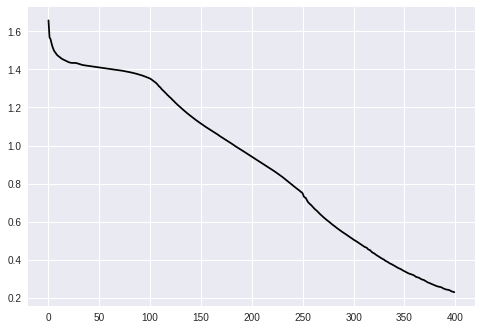

In [14]:
with tf.Session() as sess:
    sess.run(init) 
    train_loss_list = []
    test_loss_list = []
    validation_loss_list = []
    train_accuracy_list = []
    test_accuracy_list = []
    validation_accuracy_list = []
    summary_writer = tf.summary.FileWriter('./Output', sess.graph)
    for i in range(training_iters):
        batch_num = int(len(train_X)/training_iters/batch_size)
        for batch in range(batch_num):
            batch_x = train_X[(i*batch_num+batch)*batch_size:min(((i*batch_num+batch)*batch_size+1)*batch_size,len(train_X))]
            batch_y = train_y[(i*batch_num+batch)*batch_size:min(((i*batch_num+batch)*batch_size+1)*batch_size,len(train_y))]
            # Run optimization op (backprop).
                # Calculate batch loss and accuracy
            opt = sess.run(optimizer, feed_dict={x: batch_x,
                                                              y: batch_y})
            loss, acc = sess.run([cost, accuracy], feed_dict={x: batch_x,
                                                              y: batch_y})
            train_loss_list.append(loss)
            train_accuracy_list.append(acc)
            
        # Calculate accuracy for all 10000 mnist test images
        val_acc,val_loss = sess.run([accuracy,cost], feed_dict={x: val_X,y : val_y})
        validation_loss_list.append(val_loss)
        validation_accuracy_list.append(val_acc)
        print("Iter " + str(i) + ", Loss= " + \
                          "{:.6f}".format(train_loss_list[-1]) + ", Training Accuracy= " + \
                          "{:.5f}".format(train_accuracy_list[-1]))
        print("Validation Accuracy:","{:.5f}".format(val_acc))
        print("Validation Loss:","{:.5f}".format(val_loss))
    test_acc,test_loss = sess.run([accuracy,cost], feed_dict={x: test_X,y : test_y})
    test_loss_list.append(test_loss)
    test_accuracy_list.append(test_acc)
    print("Testing Accuracy:","{:.5f}".format(test_acc))
    summary_writer.close()
    plt.plot(range(len(train_loss_list)), train_loss_list, 'black', label='Training loss')
    plt.plot(range(len(train_loss_list)), validation_loss_list, 'red', label='Validation loss')
    plt.title('Training and Validation loss')
    plt.xlabel('Epochs ',fontsize=16)
    plt.ylabel('Loss',fontsize=16)
    plt.legend()
    plt.figure()
    plt.show()
    plt.plot(range(len(train_loss_list)), train_accuracy_list, 'black', label='Training Accuracy')
    plt.plot(range(len(train_loss_list)), validation_accuracy_list, 'red', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs ',fontsize=16)
    plt.ylabel('Loss',fontsize=16)
    plt.legend()
    plt.figure()
    plt.show()